# Tweet Sentiment Extraction

From Kaggle:


"My ridiculous dog is amazing." [sentiment: positive]

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

In [810]:
import tensorflow as tf
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import transformers
import tokenizers
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical  

In [811]:
tf.__version__

'2.0.0'

In [812]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_sub = pd.read_csv('../input/sample_submission.csv')

In [813]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [814]:
#print(train.dtypes)
train['textID'] = train['textID'].apply(str)
train['text'] = train['text'].apply(str)
train['selected_text'] = train['selected_text'].apply(str)
train['sentiment'] = train['sentiment'].apply(str)

test['textID'] = test['textID'].apply(str)
test['text'] = test['text'].apply(str)
test['sentiment'] = test['sentiment'].apply(str)

#### What is the task?

- Given the tweet text and the sentiment of the tweet, the task at hand is to extract the text from the tweet that reflects the sentiment. How interesting!
- One can formulate the problem as a **question-answering task**, where the sentiment is the *(short)* question, the tweet itself is the context and the selected text is the answer.

In [815]:
ex = train.loc[3,:]
context = ex.text
answer = ex.selected_text
print('Context: {}'.format(context))
print('Answer: {}'.format(answer))

Context:  what interview! leave me alone
Answer: leave me alone


In [816]:
train.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [817]:
train.loc[train.sentiment == 'neutral',['text', 'selected_text']].apply(lambda row: len(row['text'].strip())-
                                                                        len(row['selected_text'].strip()), axis=1 ).value_counts()

0      10005
1        171
2        116
3         66
27        57
       ...  
91         1
59         1
106        1
90         1
99         1
Length: 98, dtype: int64

## Tokenization and data preparation
- The tokenization logic with offsets is inspired from Abhishek Thakur's Kaggle kernel [here]( https://www.kaggle.com/abhishek/roberta-inference-5-folds).

In [818]:
# Intialize the BERT base uncased tokenizer
tokenizer = tokenizers.BertWordPieceTokenizer('../input/BERT_uncased_vocab/vocab.txt', lowercase=True)

In [819]:

def preprocess_input_data(question, context, answer, tokenizer, max_len):
    
# Tokenize and encode the question (sentiment) and the context (tweet) with special tokens
    enc = tokenizer.encode(question,context)
    input_ids = enc.ids   
    input_tokens = enc.tokens
    token_type_ids = enc.type_ids # These are the segment ids for differentiating question from context
    attention_mask = enc.attention_mask
    offsets = enc.offsets
    
    target_char_start  = context.find(answer)
    target_char_end = target_char_start + len(answer) - 1
    char_targets = [0]*len(context)
    for i in range(target_char_start,target_char_end+1):
        char_targets[i] = 1
    
    targets_index_context = []
    
    offsets_context = offsets[3:-1]
    for ind, (i,j) in enumerate(offsets_context):
        if sum(char_targets[i:j]) > 0:
            targets_index_context.append(ind) 
           
    target_start_ind = targets_index_context[0] 
    target_end_ind   = targets_index_context[-1]
    
    target_start_ind += 3
    target_end_ind += 3
    
    # padding -- pad the vectors if their lengths exceed max_len, else truncate at max_len
    pad_len = max_len - len(token_type_ids)
    if(pad_len> 0):
        token_type_ids = token_type_ids + [0]*pad_len
        input_ids = input_ids + [0]*pad_len
        attention_mask = attention_mask + [0]*pad_len
        offsets = offsets + [(0,0)]*pad_len    
    else:
        input_ids = input_ids[:max_len-1] + [102]

    
    output_dict = {'token_type_ids': token_type_ids,
                  'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'target_start': target_start_ind,
                  'target_end': target_end_ind,
                  'input_tokens': input_tokens,
                   'offsets': offsets,
                   'attention_mask': attention_mask,
                   'sentiment': question,
                   'context': context,
                   'answer': answer
                  }
    return output_dict

In [820]:
data_example = preprocess_input_data(train.sentiment[3], train.text[3], train.selected_text[3], tokenizer, max_len = 20)
print('Sentiment: ',data_example['sentiment'])
print('Tweet: ',data_example['context'])
print('Selected text: ',data_example['answer'])
print('Input tokens: ',data_example['input_tokens'])
print('Token type ids: ', data_example['token_type_ids'])
print('Input_ids: ',data_example['input_ids'])
print('Target start index: {}, Target end index: {}'.format(data_example['target_start'], data_example['target_end']))
print('Attention mask: ', data_example['attention_mask'])
print('Offsets: ',data_example['offsets'])

Sentiment:  negative
Tweet:   what interview! leave me alone
Selected text:  leave me alone
Input tokens:  ['[CLS]', 'negative', '[SEP]', 'what', 'interview', '!', 'leave', 'me', 'alone', '[SEP]']
Token type ids:  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input_ids:  [101, 4997, 102, 2054, 4357, 999, 2681, 2033, 2894, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target start index: 6, Target end index: 8
Attention mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Offsets:  [(0, 0), (0, 8), (0, 0), (1, 5), (6, 15), (15, 16), (17, 22), (23, 25), (26, 31), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


112


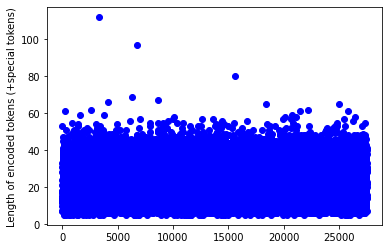

In [821]:
len_tokens = []
for i in range(train.shape[0]):
    question = train.sentiment[i]
    context= train.text[i]
    answer = train.selected_text[i]
    enc = tokenizer.encode(question,context)
    input_ids = enc.ids  
    len_tokens.append(len(input_ids))

print(max(len_tokens))
plt.plot(np.arange(len(len_tokens)), len_tokens, 'bo');
plt.ylabel('Length of encoded tokens (+special tokens)');

In [822]:
# Tokenize and encode the training set

max_len = 128

input_ids = np.zeros((train.shape[0],max_len))
token_type_ids = np.zeros((train.shape[0],max_len))
attention_mask = np.zeros((train.shape[0],max_len))
start_ids = np.zeros((train.shape[0],max_len))
end_ids = np.zeros((train.shape[0],max_len))


for i in range(train.shape[0]):
    question = train.sentiment[i]
    context= train.text[i]
    answer = train.selected_text[i]
    processed_data = preprocess_input_data(question, context, answer, tokenizer, max_len = max_len)
    input_ids[i,:] = processed_data['input_ids']
    token_type_ids[i,:] = processed_data['token_type_ids']
    attention_mask[i,:] = processed_data['attention_mask']
    start_ids[i,:] = to_categorical(processed_data['target_start'], num_classes = max_len)
    end_ids[i,:] = to_categorical(processed_data['target_end'], num_classes = max_len)

In [823]:
# Tokenize and encode the test set
def preprocess_test_data(question, context, tokenizer, max_len):
    
# Tokenize and encode the question (sentiment) and the context (tweet) with special tokens
    enc = tokenizer.encode(question,context)
    input_ids = enc.ids   
    input_tokens = enc.tokens
    token_type_ids = enc.type_ids # These are the segment ids for differentiating question from context
    attention_mask = enc.attention_mask
    offsets = enc.offsets
    
    
    # padding -- pad the vectors if their lengths exceed max_len, else truncate at max_len
    pad_len = max_len - len(token_type_ids)
    if(pad_len> 0):
        token_type_ids = token_type_ids + [0]*pad_len
        input_ids = input_ids + [0]*pad_len
        attention_mask = attention_mask + [0]*pad_len
        offsets = offsets + [(0,0)]*pad_len    
    else:
        token_type_ids = token_type_ids[:max_len]
        input_ids = input_ids[:max_len]
        attention_mask = attention_mask[:max_len]
        offsets = offsets[:max_len]

    
    output_dict = {'token_type_ids': token_type_ids,
                  'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'input_tokens': input_tokens,
                   'offsets': offsets,
                   'attention_mask': attention_mask,
                   'sentiment': question,
                   'context': context,
                  }
    return output_dict

input_ids_test = np.zeros((test.shape[0],max_len))
token_type_ids_test = np.zeros((test.shape[0],max_len))
attention_mask_test = np.zeros((test.shape[0],max_len))


for i in range(test.shape[0]):
    question = test.sentiment[i]
    context= test.text[i]
    processed_data_test = preprocess_test_data(question, context, tokenizer, max_len = max_len)
    input_ids_test[i,:] = processed_data_test['input_ids']
    token_type_ids_test[i,:] = processed_data_test['token_type_ids']
    attention_mask_test[i,:] = processed_data_test['attention_mask']


## BERT model
- The BERT output (768 dimensional vector for each token) is fed in to a CNN layer with ReLU acitvation before passing on to a linear layer with softmax activation. The output of this head represents the  probability of a token being the start index of the answer. Similarly, we construct another head for the end index.
- Dropout is added right after BERT embedding layer for regularization.

In [136]:
#    config = transformers.BertConfig()

def build_model():
    inp_ids = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    inp_tok = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    inp_att = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    
    bert_tf = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    x = bert_tf({'input_ids': inp_ids, 'token_type_ids': inp_tok, 'attention_mask': inp_att})[0]

 # Refer to https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf   


#    print(x.shape)
    h1 = tf.keras.layers.Dropout(0.1)(x) 
    h1 = tf.keras.layers.Conv1D(128, 2,padding='same')(h1)
    h1 = tf.keras.layers.BatchNormalization()(h1)
    h1 = tf.keras.layers.ReLU()(h1)
    h1 = tf.keras.layers.Dense(1)(h1)
#    print(h1.shape)
    h1 = tf.keras.layers.Flatten()(h1)
#    print(h1.shape)
    h1 = tf.keras.layers.Activation('softmax')(h1)
#    print(h1.shape)

    h2 = tf.keras.layers.Dropout(0.1)(x) 
    h2 = tf.keras.layers.Conv1D(128, 2,padding='same')(h2)
    h2 = tf.keras.layers.BatchNormalization()(h2)
    h2 = tf.keras.layers.ReLU()(h2)
    h2 = tf.keras.layers.Dense(1)(h2)
    h2 = tf.keras.layers.Flatten()(h2)
    h2 = tf.keras.layers.Activation('softmax')(h2)

    model = tf.keras.models.Model(inputs=[inp_ids, inp_att, inp_tok], outputs=[h1,h2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer = optimizer, loss='categorical_crossentropy')

    return model


In [137]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   ((None, 128, 768), ( 109482240   input_9[0][0]                    
                                                                 input_7[0][0]                

In [761]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [802]:
#Baseline jaccard score
train.apply(lambda row: jaccard(row['text'], row['selected_text']), axis=1).mean()

0.5890913411191024

In [ ]:
def train_model(input_ids, attention_mask, token_type_ids, input_ids_test,attention_mask_test,token_type_ids_test,kfold_n_splits = 5, epochs=3):
    jaccard_scores = []
    oof_start = np.zeros((input_ids.shape[0],max_len))
    oof_end = np.zeros((input_ids.shape[0],max_len))
    preds_start = np.zeros((input_ids_test.shape[0],max_len))
    preds_end = np.zeros((input_ids_test.shape[0],max_len))

    skf = StratifiedKFold(n_splits=kfold_n_splits,shuffle=True,random_state=9999)
    for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

        print('#'*25)
        print('### FOLD {}'.format(fold+1))
        print('#'*25)
        K.clear_session()
        model = build_model()
        
        sv = tf.keras.callbacks.ModelCheckpoint(
            'bert-fold{}.h5'.format(fold+1), monitor='val_loss', verbose=1, save_best_only=True,
            save_weights_only=True, mode='auto', save_freq='epoch')
        
        model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]],
              [start_ids[idxT,], end_ids[idxT,]], 
              epochs=epochs, batch_size=16, verbose=1, callbacks=[sv],
              validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
                               [start_ids[idxV,], end_ids[idxV,]]))
    
#    print('Loading model...')
#    model.load_weights('bert-fold%i.h5'%(fold))
        shutil.copy2(r'bert-fold{}.h5'.format(fold+1), r'/content/gdrive/My Drive/')
    
        print('Predicting out-of-fold answer span')
        oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=1)
      
    # DISPLAY FOLD JACCARD
        jac_oof = []
        for k in idxV:
            a = np.argmax(oof_start[k,])
            b = np.argmax(oof_end[k,])
            true_answer = train.loc[k,'selected_text']
            if (train.loc[k, 'sentiment'] == 'neutral'):
                  pred_answer = train.loc[k, 'text']
            elif a>b: 
                encoding = tokenizer.encode(train.loc[k, 'sentiment'], train.loc[k,'text'])
                pred_answer = tokenizer.decode(encoding.ids[a:-1]) 
            else:
                encoding = tokenizer.encode(train.loc[k, 'sentiment'], train.loc[k,'text'])
                pred_answer = tokenizer.decode(encoding.ids[a:b+1])        
            jac_oof.append(jaccard(pred_answer, true_answer))
        jaccard_scores.append(np.mean(jac_oof))
        print('FOLD %i Jaccard ='%(fold+1),np.mean(jac_oof))

        print('Predicting Test answer span')
        preds = model.predict([input_ids_test,attention_mask_test,token_type_ids_test])
        preds_start += preds[0]/kfold_n_splits
        preds_end += preds[1]/kfold_n_splits
    return {'pred_test_start': preds_start, 'pred_test_end': preds_end,
          'jaccard_kfold': jaccard_scores}


In [139]:
out = train_model(input_ids, attention_mask, token_type_ids, input_ids_test,attention_mask_test,token_type_ids_test,kfold_n_splits = 5, epochs=1)

In [ ]:
preds_start, preds_end = out['pred_test_start'], out['pred_test_end']
for i in range(input_ids_test.shape[0]):
    a = np.argmax(preds_start[i,])
    b = np.argmax(preds_end[i,])
    if (a>b or test.loc[i, 'sentiment'] == 'neutral'): # if start index comes after the end index
        pred_answer = test.loc[i, 'text']
        test.loc[i,'selected_text'] = pred_answer
    else:
        encoding = tokenizer.encode(test.loc[i, 'sentiment'], test.loc[i,'text'])
        pred_answer = tokenizer.decode(encoding.ids[a:b+1])  
        test.loc[i,'selected_text'] = pred_answer

In [ ]:
test[['textID', 'selected_text']].to_csv('submission.csv',index=False)

In [419]:
tokenizer = tokenizers.ByteLevelBPETokenizer(vocab_file=ROBERTA_PATH+'vocab-roberta-base.json', 
                                             merges_file=ROBERTA_PATH+'merges-roberta-base.txt', 
                                             lowercase=True,add_prefix_space=True)
text = "Hello world!"
print(text)
print('#'*5+'BPE tokenizer'+'#'*5)
enc = tokenizer.encode(text) 
print(enc.ids)
print(tokenizer.decode(enc.ids))

print('#'*5+'RoBERTa tokenizer'+'#'*5)
tokenizer_roberta = transformers.RobertaTokenizer.from_pretrained('roberta-base')
text = " " + " ".join(text.lower().split())
#text = text.lower()
encode_roberta = tokenizer_roberta.encode_plus(text, add_special_tokens=False)
print(encode_roberta['input_ids'])
#print(tokenizer_roberta.convert_ids_to_tokens(encode_roberta['input_ids']))
print(tokenizer_roberta.decode(encode_roberta['input_ids'],clean_up_tokenization_spaces=False))

Hello world!
#####BPE tokenizer#####
[20760, 232, 328]
 hello world!
#####RoBERTa tokenizer#####
[20760, 232, 328]
 hello world!


In [835]:
ROBERTA_PATH = '../input/tf-roberta/'
# Intialize the RoBERTa base tokenizer
tokenizer = tokenizers.ByteLevelBPETokenizer(vocab_file = ROBERTA_PATH+'vocab-roberta-base.json', 
                                             merges_file = ROBERTA_PATH+'merges-roberta-base.txt',
                                            lowercase = True,add_prefix_space=True)

def preprocess_input_data_roberta(question, context, answer, tokenizer, max_len):
    
# Tokenize and encode the question (sentiment) and the context (tweet) with special tokens
    context = " " + " ".join(context.split())
    answer = " " + " ".join(answer.split())
    enc_question = tokenizer.encode(question)
    enc_context = tokenizer.encode(context)
    input_ids = [0] + enc_question.ids + [2,2] +   enc_context.ids + [2]
    input_tokens = enc_question.tokens + enc_context.tokens
    token_type_ids = [0]* len(input_ids) # not relevant for RoBERTa
    attention_mask = [1]* len(input_ids)
    
    offsets_question = enc_question.offsets
    offsets_context = enc_context.offsets
    offsets = [(0,0)] + offsets_question + [(0,0)]*2 + offsets_context +[(0,0)]
    
    target_char_start  = context.find(answer)
    target_char_end = target_char_start + len(answer) - 1
    char_targets = [0]*len(context)
    for i in range(target_char_start,target_char_end+1):
        char_targets[i] = 1
    targets_index_context = []    
    for ind, (i,j) in enumerate(offsets_context):
        if sum(char_targets[i:j]) > 0:
            targets_index_context.append(ind) 
           
    target_start_ind = targets_index_context[0] + 4 
    target_end_ind   = targets_index_context[-1] + 4
    

        # padding -- pad the vectors if their lengths exceed max_len
    pad_len = max_len - len(token_type_ids)
    if(pad_len> 0):
        token_type_ids = token_type_ids + [0]*pad_len
        input_ids = input_ids + [1]*pad_len    # [1] is the <pad> token in RoBERTa
        attention_mask = attention_mask + [0]*pad_len
        offsets = offsets + [(0,0)]*pad_len    

        
    output_dict = {'token_type_ids': token_type_ids,
                  'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'target_start': target_start_ind,
                  'target_end': target_end_ind,
                  'input_tokens': input_tokens,
                   'offsets': offsets,
                   'attention_mask': attention_mask,
                   'sentiment': question,
                   'context': context,
                   'answer': answer
                  }
    return output_dict

In [836]:
data_example = preprocess_input_data_roberta(train.sentiment[3], train.text[3], train.selected_text[3], tokenizer, max_len = 15)
print('Sentiment:{}'.format(data_example['sentiment']))
print('Tweet:{}'.format(data_example['context']))
print('Selected text:{}'.format(data_example['answer']))
print('Input tokens: {}'.format(data_example['input_tokens']))
print('Token type ids: {}'.format(data_example['token_type_ids']))
print('Input_ids: {}'.format(data_example['input_ids']))
print('Target start index: {}, Target end index: {}'.format(data_example['target_start'], data_example['target_end']))
print('Attention mask: {}'.format(data_example['attention_mask']))
print('offsets: {}'.format(data_example['offsets']))

Sentiment:negative
Tweet: what interview! leave me alone
Selected text: leave me alone
Input tokens: ['Ġnegative', 'Ġwhat', 'Ġinterview', '!', 'Ġleave', 'Ġme', 'Ġalone']
Token type ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input_ids: [0, 2430, 2, 2, 99, 1194, 328, 989, 162, 1937, 2, 1, 1, 1, 1]
Target start index: 7, Target end index: 9
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
offsets: [(0, 0), (0, 8), (0, 0), (0, 0), (0, 5), (5, 15), (15, 16), (16, 22), (22, 25), (25, 31), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


In [621]:
# strip the starting blankspace at front of some tweets

#train.loc[:, 'text'] = train.loc[:, 'text'].apply(lambda tweet: tweet.strip())
#train.loc[:, 'selected_text'] = train.loc[:, 'selected_text'].apply(lambda selected_text: selected_text.strip())


In [837]:
# Tokenize and encode the training set

max_len = 128

input_ids = np.ones((train.shape[0],max_len), dtype = np.int64)
token_type_ids = np.zeros((train.shape[0],max_len), dtype = np.int8)
attention_mask = np.zeros((train.shape[0],max_len), dtype = np.int8)
start_ids = np.zeros((train.shape[0],max_len), dtype = np.int64)
end_ids = np.zeros((train.shape[0],max_len), dtype = np.int64)


for i in range(train.shape[0]):
    question = train.sentiment[i]
    context= train.text[i]
    answer = train.selected_text[i]
    processed_data = preprocess_input_data_roberta(question, context, answer, tokenizer, max_len = max_len)
    input_ids[i,:] = processed_data['input_ids']
    token_type_ids[i,:] = processed_data['token_type_ids']
    attention_mask[i,:] = processed_data['attention_mask']
    start_ids[i,:] = to_categorical(processed_data['target_start'], num_classes = max_len)
    end_ids[i,:] = to_categorical(processed_data['target_end'], num_classes = max_len)

In [831]:
def process_data_abhishek(tweet, selected_text, sentiment, tokenizer, max_len):
    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break
    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    
    tok_tweet = tokenizer.encode(tweet)
    input_ids_orig = tok_tweet.ids
    tweet_offsets = tok_tweet.offsets
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    sentiment_id = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }
    
    input_ids = [0] + [sentiment_id[sentiment]] + [2] + [2] + input_ids_orig + [2]
    token_type_ids = [0, 0, 0, 0] + [0] * (len(input_ids_orig) + 1)
    mask = [1] * len(token_type_ids)
    tweet_offsets = [(0, 0)] * 4 + tweet_offsets + [(0, 0)]
    targets_start += 4
    targets_end += 4

    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([1] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        tweet_offsets = tweet_offsets + ([(0, 0)] * padding_length)
    
    return {
        'ids': input_ids,
        'mask': mask,
        'token_type_ids': token_type_ids,
        'targets_start': targets_start,
        'targets_end': targets_end,
        'orig_tweet': tweet,
        'orig_selected': selected_text,
        'sentiment': sentiment,
        'offsets': tweet_offsets
    }


In [832]:
k=3
out = process_data_abhishek(train.text[k], train.selected_text[k], train.sentiment[k], tokenizer, max_len=15)
print('Sentiment:{}'.format(out['sentiment']))
print('Tweet:{}'.format(out['orig_tweet']))
print('Selected text:{}'.format(out['orig_selected']))
print('Token type ids: {}'.format(out['token_type_ids']))
print('Input_ids: {}'.format(out['ids']))
print('Target start index: {}, Target end index: {}'.format(out['targets_start'], out['targets_end']))
print('Attention mask: {}'.format(out['mask']))
print('offsets: {}'.format(out['offsets']))

Sentiment:negative
Tweet: what interview! leave me alone
Selected text: leave me alone
Token type ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input_ids: [0, 2430, 2, 2, 101, 2054, 4357, 999, 2681, 2033, 2894, 102, 2, 1, 1]
Target start index: 8, Target end index: 10
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
offsets: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 5), (6, 15), (15, 16), (17, 22), (23, 25), (26, 31), (0, 0), (0, 0), (0, 0), (0, 0)]


In [833]:
tokenizer.decode([out['ids'][out['targets_start']]])

'leave'

In [838]:

input_ids_a = np.ones((train.shape[0],max_len), dtype = np.int64)
token_type_ids_a = np.zeros((train.shape[0],max_len), dtype = np.int8)
attention_mask_a = np.zeros((train.shape[0],max_len), dtype = np.int8)
start_ids_a = np.zeros((train.shape[0],max_len), dtype = np.int64)
end_ids_a = np.zeros((train.shape[0],max_len), dtype = np.int64)


for i in range(train.shape[0]):
    question = train.sentiment[i]
    context= train.text[i]
    answer = train.selected_text[i]
    processed_data = process_data_abhishek(context, answer, question,tokenizer, max_len = max_len)
    input_ids_a[i,:] = processed_data['ids']
    token_type_ids_a[i,:] = processed_data['token_type_ids']
    attention_mask_a[i,:] = processed_data['mask']


In [847]:
((input_ids_a == input_ids).sum(axis=1)==128).sum() == input_ids.shape[0]

True

## example tokenization: RoBERTa

In [894]:
context = 'Hello world, excited to be here!'
question = 'positive'
answer = 'excited to be'

context = " " + " ".join(context.split()) 
answer = " " + " ".join(answer.split())

enc_question = tokenizer.encode(question)
enc_context = tokenizer.encode(context)
input_ids = [0] + enc_question.ids + [2,2] +   enc_context.ids + [2]
input_tokens = enc_question.tokens + enc_context.tokens
token_type_ids = [0]* len(input_ids) # not relevant for RoBERTa
attention_mask = [1]* len(input_ids)

offsets_question = enc_question.offsets
offsets_context = enc_context.offsets
offsets = [(0,0)] + offsets_question + [(0,0)]*2 + offsets_context +[(0,0)]

target_char_start  = context.find(answer)
target_char_end = target_char_start + len(answer) - 1
char_targets = [0]*len(context)
for i in range(target_char_start,target_char_end+1):
    char_targets[i] = 1
targets_index_context = []    
for ind, (i,j) in enumerate(offsets_context):
    if sum(char_targets[i:j]) > 0:
        targets_index_context.append(ind) 

target_start_ind = targets_index_context[0] + 4 
target_end_ind   = targets_index_context[-1] + 4

In [895]:
offsets_context

[(0, 6), (6, 12), (12, 13), (13, 21), (21, 24), (24, 27), (27, 32), (32, 33)]

In [896]:
enc_context.tokens

['Ġhello', 'Ġworld', ',', 'Ġexcited', 'Ġto', 'Ġbe', 'Ġhere', '!']

In [897]:
enc_ids = [0] + enc_question.ids + [2,2] +   enc_context.ids + [2]
tokenizer.decode(enc_ids[target_start_ind:target_end_ind+1])

' excited to be'

In [898]:
answer

' excited to be'